In [1]:
import sys
sys.path.append("/usr/local/python-env/py39/lib/python3.9/site-packages")

import pyspark
print(pyspark.__version__)

print(sys.executable)

3.5.0
/bin/python3.9


In [2]:
import os

os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.9'

In [3]:
import pkg_resources

sedona_version = pkg_resources.get_distribution("apache-sedona").version
print(f"Apache Sedona version: {sedona_version}")

Apache Sedona version: 1.5.1


In [4]:
print(os.environ['SPARK_HOME'])
print(os.environ['PYSPARK_PYTHON'])

/usr/local/spark/latest
/usr/bin/python3.9


In [5]:
from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from pyspark.sql.functions import col
from pyspark.sql import functions as F


In [6]:
spark = SparkSession \
    .builder \
    .appName("GraphFramesExample") \
    .master('spark://hartford:30196') \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12") \
    .config("spark.yarn.resourcemanager.address", "columbia.cs.colostate.edu:30799") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
logger = spark._jvm.org.apache.log4j.LogManager.getLogger(__name__)


:: loading settings :: url = jar:file:/usr/local/spark/3.5.0-with-hadoop3.3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /s/chopin/l/grad/ebmartin/.ivy2/cache
The jars for the packages stored in: /s/chopin/l/grad/ebmartin/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8ac2d60c-c4e2-4f98-a6a2-f5dbc7988170;1.0
	confs: [default]
	found graphframes#graphframes;0.8.3-spark3.4-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 74ms :: artifacts dl 11ms
	:: modules in use:
	graphframes#graphframes;0.8.3-spark3.4-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-------

In [7]:
# Import the necessary module from py4j to interact with JVM
from py4j.java_gateway import java_import

# Import the Path class from Hadoop. This class is used to handle file paths in Hadoop.
java_import(spark._jvm, 'org.apache.hadoop.fs.Path')

fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())

In [8]:
def get_csv_df(file_name: str):
    data_directory = "hdfs://hartford.cs.colostate.edu:30181/geospatial/input/knowledge_graphs/"
    print(f"Processing file: {file_name}")

    if "Nodes" in file_name:
        schema = "Node_ID string, Type string"
        df = spark.read.format("csv").option("header", "true").schema(schema).load(data_directory + file_name)
        df = df.withColumnRenamed("Node_ID", "id")  # Rename column for GraphFrame compatibility
    elif "Edges" in file_name:
        schema = "Subject string, Relationship string, Object string"
        df = spark.read.format("csv").option("header", "true").schema(schema).load(data_directory + file_name)
        df = df.withColumnRenamed("Subject", "src").withColumnRenamed("Object", "dst")  # Rename columns for GraphFrame compatibility
    else:
        df = None

    return df


In [9]:
from graphframes import *

In [10]:
# Load the nodes and edges data
nodes_df = get_csv_df("BaseNodes.csv")
edges_df = get_csv_df("BaseEdges.csv")

Processing file: BaseNodes.csv
Processing file: BaseEdges.csv


In [11]:
print(nodes_df.columns)
print(edges_df.columns)

['id', 'Type']
['src', 'Relationship', 'dst']


In [12]:
nodes_df.show()
edges_df.show()

+--------------------+-----+
|                  id| Type|
+--------------------+-----+
|BlockGroup_010890...|Block|
|BlockGroup_011010...|Block|
|BlockGroup_011250...|Block|
|BlockGroup_010310...|Block|
|BlockGroup_010830...|Block|
|BlockGroup_010439...|Block|
|BlockGroup_010730...|Block|
|BlockGroup_011170...|Block|
|BlockGroup_011030...|Block|
|BlockGroup_010970...|Block|
|BlockGroup_010770...|Block|
|BlockGroup_010259...|Block|
|BlockGroup_010730...|Block|
|BlockGroup_010199...|Block|
|BlockGroup_010950...|Block|
|BlockGroup_010499...|Block|
|BlockGroup_010730...|Block|
|BlockGroup_010670...|Block|
|BlockGroup_011010...|Block|
|BlockGroup_010890...|Block|
+--------------------+-----+
only showing top 20 rows



+--------------------+------------+-----------------+
|                 src|Relationship|              dst|
+--------------------+------------+-----------------+
|BlockGroup_010730...|    isPartOf|Tract_01073010500|
|BlockGroup_010730...|    isPartOf|Tract_01073010703|
|BlockGroup_010970...|    isPartOf|Tract_01097005100|
|BlockGroup_011170...|    isPartOf|Tract_01117030616|
|BlockGroup_010770...|    isPartOf|Tract_01077011605|
|BlockGroup_010730...|    isPartOf|Tract_01073005000|
|BlockGroup_011010...|    isPartOf|Tract_01101001100|
|BlockGroup_010810...|    isPartOf|Tract_01081040602|
|BlockGroup_010150...|    isPartOf|Tract_01015001300|
|BlockGroup_010139...|    isPartOf|Tract_01013953200|
|BlockGroup_010890...|    isPartOf|Tract_01089010625|
|BlockGroup_010030...|    isPartOf|Tract_01003011503|
|BlockGroup_011250...|    isPartOf|Tract_01125011402|
|BlockGroup_010970...|    isPartOf|Tract_01097003301|
|BlockGroup_010030...|    isPartOf|Tract_01003010100|
|BlockGroup_010890...|    is

# =========================================================================

# GRAPH METRICS AND ANALYSIS

# =========================================================================

Create the graph frame object

In [13]:
g = GraphFrame(nodes_df, edges_df)

# Set checkpoint directory
spark.sparkContext.setCheckpointDir('hdfs://hartford.cs.colostate.edu:30181/geospatial/input/knowledge_graphs/checkpoints/')


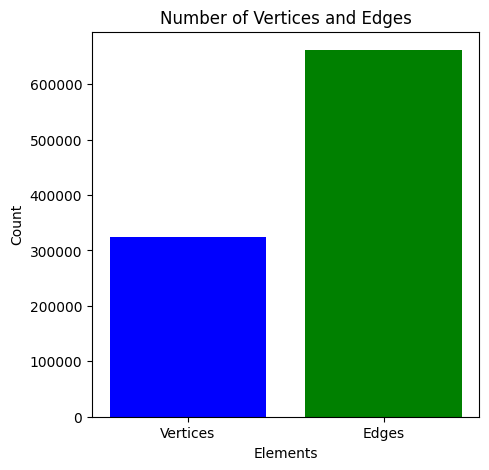

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the number of vertices and edges
num_vertices = g.vertices.count()
num_edges = g.edges.count()

# Create a DataFrame with the counts
df = pd.DataFrame({'Elements': ['Vertices', 'Edges'], 'Count': [num_vertices, num_edges]})

# Plot the counts
plt.figure(figsize=(5, 5))
plt.bar(df['Elements'], df['Count'], color=['blue', 'green'])
plt.title('Number of Vertices and Edges')
plt.xlabel('Elements')
plt.ylabel('Count')
plt.show()

# Save the plot
plt.savefig('/s/chopin/l/grad/ebmartin/CS555/Term_Project/Excavating_GeoSpatial_Insights_from_DataLakes/notebooks/figures/base_KG_vertices_edges_count.png')

# Calculate the in and out degree of the vertices

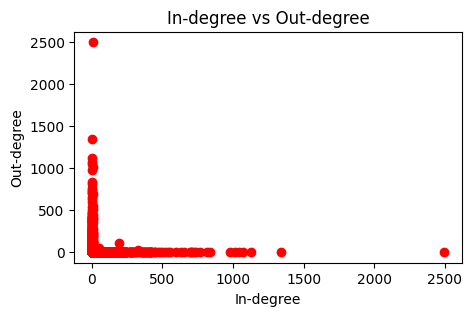

<Figure size 640x480 with 0 Axes>

In [37]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Calculate the in-degree of the vertices
in_degree = g.inDegrees

# Calculate the out-degree of the vertices
out_degree = g.outDegrees

# plot the in-degree and out-degree of the vertices
plt.figure(figsize=(5, 3))
plt.scatter(in_degree.toPandas()['inDegree'], out_degree.toPandas()['outDegree'], color='red')
plt.title('In-degree vs Out-degree')
plt.xlabel('In-degree')
plt.ylabel('Out-degree')
plt.show()

plt.savefig('/s/chopin/l/grad/ebmartin/CS555/Term_Project/Excavating_GeoSpatial_Insights_from_DataLakes/notebooks/figures/base_KG_in_out_degree.png')

<Figure size 500x500 with 0 Axes>

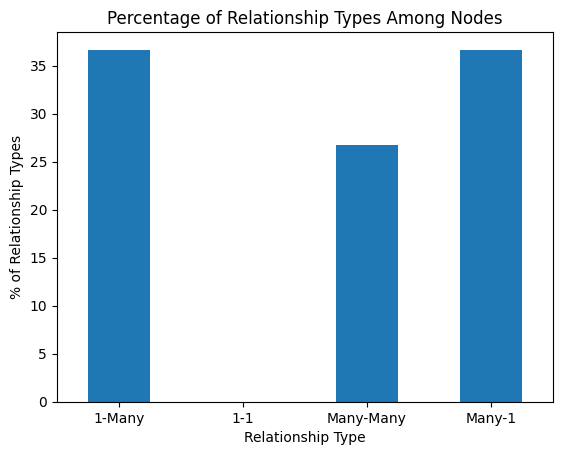

<Figure size 640x480 with 0 Axes>

In [35]:

# Join the edges with the in-degrees and out-degrees
edges_with_degrees = g.edges.alias("e") \
    .join(in_degree.alias("src_in"), col("e.src") == col("src_in.id")) \
    .join(out_degree.alias("src_out"), col("e.src") == col("src_out.id")) \
    .join(in_degree.alias("dst_in"), col("e.dst") == col("dst_in.id")) \
    .join(out_degree.alias("dst_out"), col("e.dst") == col("dst_out.id"))

# Define a UDF to categorize the edges
def categorize_edge(src_in, src_out, dst_in, dst_out):
    if src_out > 1 and dst_in > 1:
        return "Many-Many"
    elif src_out > 1 and dst_in == 1:
        return "Many-1"
    elif src_out == 1 and dst_in > 1:
        return "1-Many"
    else:
        return "1-1"
categorize_edge_udf = udf(categorize_edge, StringType())

# Categorize the edges
edges_with_categories = edges_with_degrees.withColumn("category", categorize_edge_udf("src_in.inDegree", "src_out.outDegree", "dst_in.inDegree", "dst_out.outDegree"))

# Count the number of edges in each category
category_counts = edges_with_categories.groupBy("category").count()

# Convert to pandas DataFrame for plotting
category_counts_pd = category_counts.toPandas()

# Plot the percentage of each category
category_counts_pd['percentage'] = category_counts_pd['count'] / category_counts_pd['count'].sum() * 100
# Convert to pandas DataFrame for plotting
category_counts_pd = category_counts.toPandas()

# Calculate the percentage of each category
category_counts_pd['percentage'] = category_counts_pd['count'] / category_counts_pd['count'].sum() * 100

# Plot the percentage of each category
plt.figure(figsize=(5, 5))
ax = category_counts_pd.plot(x='category', y='percentage', kind='bar', legend=False)
plt.ylabel('% of Relationship Types')
plt.xlabel('Relationship Type')
plt.title('Percentage of Relationship Types Among Nodes')

# Make x-axis labels horizontal
plt.xticks(rotation='horizontal')

plt.show()

plt.savefig('/s/chopin/l/grad/ebmartin/CS555/Term_Project/Excavating_GeoSpatial_Insights_from_DataLakes/notebooks/figures/base_KG_relationship_types.png')

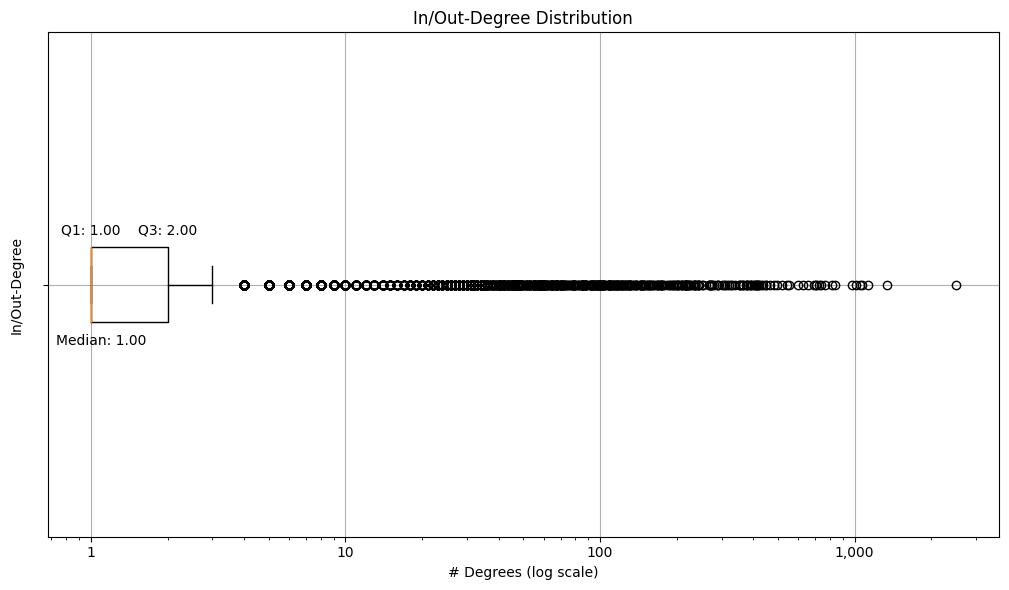

In [76]:
import matplotlib.ticker as ticker

# Create a box and whisker plot using seaborn for better aesthetics
plt.figure(figsize=(10, 6))
bp = plt.boxplot(df['In-degree'], vert=False, )
plt.title('In/Out-Degree Distribution')
plt.xlabel('# Degrees (log scale)')
plt.grid(True)  # Adding grid for better readability
plt.tight_layout()  # Ensuring everything fits without overlapping
# Set the x-axis to be logarithmic
plt.xscale('log', base=10)

# Format the x-ticks as integers
plt.gca().get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0,d}'.format(int(x))))

# Change the y-axis label and rotate it to be vertical
plt.gca().set_ylabel('In/Out-Degree', rotation=90, labelpad=10)

# Remove the y-tick labels
plt.gca().set_yticklabels([])

# Get the important values
median = bp['medians'][0].get_xdata()[0]
q1 = bp['boxes'][0].get_xdata()[0]
q3 = bp['boxes'][0].get_xdata()[2]

# Add the important values above the box plot
plt.text(median + 0.1, 0.88, f'Median: {median:.2f}', ha='center')
plt.text(q1, 1.1, f'Q1: {q1:.2f}', ha='center')
plt.text(q3, 1.1, f'Q3: {q3:.2f}', ha='center')

# Save the figure
file_path = '/s/chopin/l/grad/ebmartin/CS555/Term_Project/Excavating_GeoSpatial_Insights_from_DataLakes/notebooks/figures/base_KG_in_degree_boxplot.png'
plt.savefig(file_path)

# Page Rank Algorithm

Notice the namespace collisions.

In [79]:
# Graph Frames page rank 
results = g.pageRank(resetProbability=0.15, tol=0.01)
results.vertices.orderBy(F.desc("pagerank")).show()
results.edges.withColumn("weight", col("weight").cast("float")).orderBy(F.desc("weight")).show()


+--------------+------+-----------------+
|            id|  Type|         pagerank|
+--------------+------+-----------------+
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
| County_Harris|County|629.4496687056359|
| County_Harris|County|629.4496687056359|
|County_Suffolk|County|405.5873200441693|
|County_Suffolk|County|405.5873200441693|
| County_Monroe|County|  383.69214961953|
+--------------+------+-----------

+-----------------+------------+--------------------+------+
|              src|Relationship|                 dst|weight|
+-----------------+------------+--------------------+------+
|Tract_01073011704|    Contains|BlockGroup_010730...|   1.0|
|Tract_01073005910|    Contains|BlockGroup_010730...|   1.0|
|Tract_01059972900|    Contains|BlockGroup_010599...|   1.0|
|Tract_01097003203|    Contains|BlockGroup_010970...|   1.0|
|Tract_01105687001|    Contains|BlockGroup_011056...|   1.0|
|Tract_01073010802|    Contains|BlockGroup_010730...|   1.0|
|Tract_01089001901|    Contains|BlockGroup_010890...|   1.0|
|Tract_01015981903|    Contains|BlockGroup_010159...|   1.0|
|Tract_01073012001|    Contains|BlockGroup_010730...|   1.0|
|Tract_01073011110|    Contains|BlockGroup_010730...|   1.0|
|Tract_01063060102|    Contains|BlockGroup_010630...|   1.0|
|Tract_01031010600|    Contains|BlockGroup_010310...|   1.0|
|Tract_01073002900|    Contains|BlockGroup_010730...|   1.0|
|Tract_01073011113|    C

## We will check to see if there is namespace collision

We notice that the counties, states, countries, and continents do not have unique identifiers which leads to the page rank algorithm and possibly other algorithms to not work properly.

In [87]:
g.edges.filter("src == 'County_Walker' AND Relationship == 'isPartOf'").show(100)
g.edges.filter("dst LIKE 'County_Wa%'").show(100)

+-------------+------------+-------------+
|          src|Relationship|          dst|
+-------------+------------+-------------+
|County_Walker|    isPartOf|State_Alabama|
|County_Walker|    isPartOf|State_Georgia|
|County_Walker|    isPartOf|  State_Texas|
+-------------+------------+-------------+

+-----------------+------------+-------------------+
|              src|Relationship|                dst|
+-----------------+------------+-------------------+
|Tract_01127021100|    isPartOf|      County_Walker|
|Tract_01127021000|    isPartOf|      County_Walker|
|Tract_01127021600|    isPartOf|      County_Walker|
|Tract_01127021300|    isPartOf|      County_Walker|
|Tract_01127021400|    isPartOf|      County_Walker|
|Tract_01127021500|    isPartOf|      County_Walker|
|Tract_01127021700|    isPartOf|      County_Walker|
|Tract_01127021800|    isPartOf|      County_Walker|
|Tract_01127020100|    isPartOf|      County_Walker|
|Tract_01127020600|    isPartOf|      County_Walker|
|Tract_01

In [85]:
# g.edges.filter("src == 'County_Walker' AND dst LIKE 'State_%'").show(100)
g.edges.filter("src == 'County_Walker' AND Relationship == 'isPartOf'").show(100)


+-------------+------------+-------------+
|          src|Relationship|          dst|
+-------------+------------+-------------+
|County_Walker|    isPartOf|State_Alabama|
|County_Walker|    isPartOf|State_Georgia|
|County_Walker|    isPartOf|  State_Texas|
+-------------+------------+-------------+



# Example Queries of the Base Knowledge Graph

We can query the base knowledge graph with SQL queries, Motif queries, and GraphFrames queries.

## SQL Query Examples:

SQL queries are a powerful tool for filtering and manipulating structured data. In the context of graph analysis, we can use SQL queries to perform operations like selecting nodes or edges based on certain criteria, counting the number of nodes or edges, or aggregating data in other ways. SQL queries are particularly useful when we need to perform complex aggregations or join operations.

In [95]:
g.edges.filter("src == 'State_Colorado'").show()
g.edges.filter("src LIKE 'County_J%' AND Relationship == 'isPartOf' AND dst == 'State_Colorado'").show(100)
g.edges.filter("dst LIKE 'County_Wa%'").show(100)
g.edges.filter("src == 'State_Colorado' OR dst == 'State_Colorado'").show(100)
g.vertices.filter("Type == 'State'").show(100)
g.vertices.createOrReplaceTempView("vertices")
spark.sql("SELECT * FROM vertices WHERE id = 'County_Mineral'").show()


+--------------+------------+--------------------+
|           src|Relationship|                 dst|
+--------------+------------+--------------------+
|State_Colorado|    isPartOf|Country_United St...|
|State_Colorado|    Contains|    County_Archuleta|
|State_Colorado|    Contains|     County_La Plata|
|State_Colorado|    Contains|    County_Montezuma|
|State_Colorado|    Contains|   County_Rio Grande|
|State_Colorado|    Contains|      County_Mineral|
|State_Colorado|    Contains|      County_Dolores|
|State_Colorado|    Contains|     County_San Juan|
|State_Colorado|    Contains|     County_Hinsdale|
|State_Colorado|    Contains|   County_San Miguel|
|State_Colorado|    Contains|        County_Ouray|
|State_Colorado|    Contains|      County_Conejos|
|State_Colorado|    Contains|     County_Costilla|
|State_Colorado|    Contains|      County_Alamosa|
|State_Colorado|    Contains|     County_Huerfano|
|State_Colorado|    Contains|     County_Saguache|
|State_Colorado|    Contains|  

## Motif Examples

**Motifs:**

Motifs are a way of finding certain patterns or structures within the graph. A motif is a small connected subgraph, and finding motifs involves looking for occurrences of this subgraph within the larger graph. This can be useful for identifying certain types of relationships or structures within the graph.

**DataFrame Manipulations:**

We can also use DataFrame manipulations to perform operations on the graph data. This can involve filtering, grouping, or aggregating data in various ways. DataFrame manipulations are particularly useful when we need to perform complex transformations on the data or when we want to combine data from multiple sources.

In [103]:
# Find all states that are part of the 'Country_United States of America'
# a is the source vertex, b is the destination vertex, and ab is the edge between them
motifs = g.find("(a)-[ab]->(b)")
motifs = motifs.filter("a.Type = 'State' AND b.id = 'Country_United States of America' AND ab.relationship = 'isPartOf'")

# Display the result
motifs.show(10)

# Print the number of states
print(motifs.count())

+--------------------+--------------------+--------------------+
|                   a|                  ab|                   b|
+--------------------+--------------------+--------------------+
|{State_Mississipp...|{State_Mississipp...|{Country_United S...|
|{State_North Caro...|{State_North Caro...|{Country_United S...|
|{State_Oklahoma, ...|{State_Oklahoma, ...|{Country_United S...|
|{State_Virginia, ...|{State_Virginia, ...|{Country_United S...|
|{State_West Virgi...|{State_West Virgi...|{Country_United S...|
|{State_Louisiana,...|{State_Louisiana,...|{Country_United S...|
|{State_Michigan, ...|{State_Michigan, ...|{Country_United S...|
|{State_Massachuse...|{State_Massachuse...|{Country_United S...|
|{State_Idaho, State}|{State_Idaho, isP...|{Country_United S...|
|{State_Florida, S...|{State_Florida, i...|{Country_United S...|
+--------------------+--------------------+--------------------+
only showing top 10 rows

50


In [111]:
motifs = g.find("(a)-[ab]->(b)")

# Filter the motifs where 'a' is a state or country, 'ab' is 'isPartOf' relationship, and 'b' is not 'Continent_North America' or 'Planet_Earth'
filtered_motifs = motifs.filter(
    (motifs['a']['Type'] == 'Country') &
    (motifs['ab']['Relationship'] == 'isPartOf') &
    (motifs['b']['id'] != 'Continent_North America')
)

# Select the states or countries that don't have a 'isPartOf' relationship with 'Continent_North America' or 'Planet_Earth'
states_countries = filtered_motifs.select("a.id").distinct()

states_countries.show()

+--------------------+
|                  id|
+--------------------+
|     Country_Bahrain|
|Country_Jarvis Is...|
|     Country_Belarus|
|Country_Jammu-Kas...|
|Country_South Africa|
|Country_Glorioso ...|
|     Country_Ecuador|
|  Country_Madagascar|
|Country_The forme...|
|     Country_Hungary|
|Country_Iran (Isl...|
|       Country_China|
|       Country_Malta|
|Country_Heard Isl...|
|     Country_Iceland|
|    Country_Guernsey|
|       Country_Gabon|
|Country_Lao Peopl...|
|     Country_Senegal|
|     Country_Germany|
+--------------------+
only showing top 20 rows



In [119]:
# Find all motifs where 'a' is a country, 'ab' is 'isPartOf' relationship, and 'b' is 'Continent_North America'
motifs = g.find("(a)-[ab]->(b)").filter("a.Type = 'Country' AND ab.Relationship = 'isPartOf' AND b.id = 'Continent_North America'")

# Select the 'id' of 'a' from these motifs and remove duplicates
countries_with_north_america = motifs.select("a.id").distinct()

# Find all countries
all_countries = g.vertices.filter("Type = 'Country'")

# Find countries without a 'isPartOf' relationship with 'Continent_North America' by subtracting countries_with_north_america from all_countries
countries_without_north_america = all_countries.join(countries_with_north_america, all_countries.id == countries_with_north_america['id'], 'left_anti')

print("Countries without 'isPartOf' relationship with 'Continent_North America':")
print(f'There are {countries_without_north_america.count()} countries without a relationship with "Continent_North America"')
countries_without_north_america.show()

Countries without 'isPartOf' relationship with 'Continent_North America':
There are 189 countries without a relationship with "Continent_North America"
+--------------------+-------+
|                  id|   Type|
+--------------------+-------+
|     Country_Bahrain|Country|
|Country_Jarvis Is...|Country|
|     Country_Belarus|Country|
|Country_Jammu-Kas...|Country|
|Country_South Africa|Country|
|Country_Glorioso ...|Country|
|     Country_Ecuador|Country|
|  Country_Madagascar|Country|
|Country_The forme...|Country|
|     Country_Hungary|Country|
|Country_Iran (Isl...|Country|
|       Country_China|Country|
|       Country_Malta|Country|
|Country_Heard Isl...|Country|
|     Country_Iceland|Country|
|    Country_Guernsey|Country|
|       Country_Gabon|Country|
|Country_Lao Peopl...|Country|
|     Country_Senegal|Country|
|     Country_Germany|Country|
+--------------------+-------+
only showing top 20 rows



In [121]:
# Find all motifs where 'a' is a country, 'ab' is 'isPartOf' relationship, and 'b' is 'Continent_North America'
motifs = g.find("(a)-[ab]->(b)").filter("a.Type = 'State' AND ab.Relationship = 'isPartOf' AND b.id = 'Country_United States of America'")

# Select the 'id' of 'a' from these motifs and remove duplicates
states_with_usa = motifs.select("a.id").distinct()

# Find all countries
all_states = g.vertices.filter("Type = 'State'")

# Find countries without a 'isPartOf' relationship with 'Continent_North America' by subtracting countries_with_north_america from all_countries
states_without_usa = all_states.join(states_with_usa, all_states.id == states_with_usa['id'], 'left_anti')

print("States without 'isPartOf' relationship with 'Country_United States of America':")
print(f'There are {states_without_usa.count()} states without a relationship with the USA')
states_without_usa.show()

States without 'isPartOf' relationship with 'Country_United States of America':
There are 2 states without a relationship with the USA
+-----------------+-----+
|               id| Type|
+-----------------+-----+
|       State_Guam|State|
|State_Puerto Rico|State|
+-----------------+-----+



In [124]:
# Find all motifs where 'a' is a county, 'ab' is 'isPartOf' relationship, and 'b' is 'State'
motifs = g.find("(a)-[ab]->(b)").filter("a.Type = 'County' AND ab.Relationship = 'isPartOf' AND b.Type = 'State'")

# Select the 'id' of 'a' from these motifs and remove duplicates
counties_with_states = motifs.select("a.id").distinct()

# Find all countries
all_counties = g.vertices.filter("Type = 'County'")

# Find countries without a 'isPartOf' relationship with 'Continent_North America' by subtracting countries_with_north_america from all_countries
counties_without_states = all_counties.join(counties_with_states, all_counties.id == counties_with_states['id'], 'left_anti')

print("Counties without 'isPartOf' relationship with 'State':")
print(f'There are {counties_without_states.count()} counties without a relationship with a state')
counties_without_states.show()

Counties without 'isPartOf' relationship with 'State':
There are 9 counties without a relationship with a state
+--------------------+------+
|                  id|  Type|
+--------------------+------+
|      County_Western|County|
|         County_Rota|County|
|County_Swains Island|County|
|       County_Hawaii|County|
|        County_Kauai|County|
|         County_Maui|County|
|      County_Eastern|County|
|       County_Saipan|County|
|     County_St. John|County|
+--------------------+------+



# Aggregation Queries

In [19]:
demographics_df = spark.read.csv("demographics.csv", header=True, inferSchema=True)

# Aggregate data for each tract
tract_data = demographics_df \
    .join(edges_df, edges_df["dst"] == demographics_df["BlockGroupID"]) \
    .groupBy("src") \
    .agg(sum("Population").alias("TotalPopulation"))

AnalysisException: [PATH_NOT_FOUND] Path does not exist: hdfs://hartford.cs.colostate.edu:30181/user/ebmartin/demographics.csv.

# Proximity Queries

In [ ]:
# Assuming 'lat' and 'lon' columns exist and 'point_lat' and 'point_lon' are given
from pyspark.sql.functions import expr

radius_query = nodes_df.filter(
    expr(f"ST_Distance(ST_Point(lon, lat), ST_Point({point_lon}, {point_lat})) <= {radius}")
)

# Shortest paths:

Computes the shortest paths from each vertex to the given set of landmark vertices.

In [ ]:
results = g.shortestPaths(landmarks=["County_Wayne"])

results.show()

+--------------------+-----+-------------------+
|                  id| Type|          distances|
+--------------------+-----+-------------------+
|BlockGroup_181270...|Block|                 {}|
|   Tract_42029302703|Tract|                 {}|
|BlockGroup_230310...|Block|                 {}|
|BlockGroup_260172...|Block|                 {}|
|BlockGroup_360290...|Block|                 {}|
|BlockGroup_360593...|Block|                 {}|
|BlockGroup_060371...|Block|                 {}|
|   Tract_42041011602|Tract|{County_Wayne -> 5}|
|BlockGroup_160139...|Block|                 {}|
|BlockGroup_060376...|Block|                 {}|
|   Tract_29510127800|Tract|                 {}|
|BlockGroup_291833...|Block|                 {}|
|   Tract_42055012100|Tract|                 {}|
|BlockGroup_200910...|Block|                 {}|
|BlockGroup_470010...|Block|                 {}|
|BlockGroup_280059...|Block|                 {}|
|BlockGroup_060014...|Block|                 {}|
|   Tract_3915593110

# Triangle count

Counts the number of triangles passing through each vertex, providing a measure of clustering.

In [ ]:
results = g.triangleCount()

# sort by count
results.orderBy("count", ascending=False).show()
results.show()


+-----+--------------------+-----+
|count|                  id| Type|
+-----+--------------------+-----+
|    0|   Tract_25003933300|Tract|
|    0|BlockGroup_011010...|Block|
|    0|   Tract_25027746100|Tract|
|    0|BlockGroup_011170...|Block|
|    0|   Tract_25017336402|Tract|
|    0|BlockGroup_011250...|Block|
|    0|   Tract_25023530300|Tract|
|    0|BlockGroup_010030...|Block|
|    0|   Tract_25005610204|Tract|
|    0|BlockGroup_010810...|Block|
|    0|   Tract_25009221700|Tract|
|    0|BlockGroup_010799...|Block|
|    0|   Tract_25001014900|Tract|
|    0|BlockGroup_010030...|Block|
|    0|   Tract_25023525204|Tract|
|    0|BlockGroup_010550...|Block|
|    0|   Tract_25021440102|Tract|
|    0|BlockGroup_011310...|Block|
|    0|   Tract_25017383700|Tract|
|    0|BlockGroup_010872...|Block|
+-----+--------------------+-----+
only showing top 20 rows



+-----+-----------------+-----+
|count|               id| Type|
+-----+-----------------+-----+
|    0|Tract_47037017701|Tract|
|    0|Tract_47041920101|Tract|
|    0|Tract_47157009501|Tract|
|    0|Tract_47157008700|Tract|
|    0|Tract_47157020653|Tract|
|    0|Tract_47019071600|Tract|
|    0|Tract_47137925102|Tract|
|    0|Tract_47113001300|Tract|
|    0|Tract_47113001612|Tract|
|    0|Tract_47093005909|Tract|
|    0|Tract_47153060200|Tract|
|    0|Tract_47163041600|Tract|
|    0|Tract_47111970200|Tract|
|    0|Tract_47011011501|Tract|
|    0|Tract_47165020904|Tract|
|    0|Tract_47063100100|Tract|
|    0|Tract_47157021357|Tract|
|    0|Tract_47157011401|Tract|
|    0|Tract_47125102100|Tract|
|    0|Tract_47003950100|Tract|
+-----+-----------------+-----+
only showing top 20 rows



In [ ]:
results = g.stronglyConnectedComponents(maxIter=10)

results.show()

+--------------------+-----+-----------+
|                  id| Type|  component|
+--------------------+-----+-----------+
|   Tract_42069100500|Tract|      49840|
|BlockGroup_051074...|Block|17179874016|
|BlockGroup_320030...|Block|17179929341|
|BlockGroup_080319...|Block|17179887086|
|BlockGroup_391010...|Block|      46044|
|BlockGroup_483379...|Block|17179967366|
|BlockGroup_080770...|Block|         41|
|   Tract_34039035500|Tract|         41|
|   Tract_53001950100|Tract| 8590020586|
|BlockGroup_091900...|Block|         41|
|BlockGroup_483030...|Block|17179967045|
|BlockGroup_010730...|Block|        474|
|   Tract_05119004226|Tract| 8590000008|
|BlockGroup_450439...|Block|17179958043|
|BlockGroup_530330...|Block|      60033|
|   Tract_47125101702|Tract| 8589988079|
|BlockGroup_260992...|Block|17179919889|
|   Tract_48439113716|Tract|         41|
|BlockGroup_420110...|Block|17179953027|
|BlockGroup_482150...|Block| 8589991608|
+--------------------+-----+-----------+
only showing top

In [33]:
from pyspark.sql.functions import col

# Reverse the edges
reversed_edges = g.edges.select(col("dst").alias("src"), col("src").alias("dst"), col("relationship"))

# Add the reversed edges to the graph
undirected_graph = GraphFrame(g.vertices, g.edges.union(reversed_edges))

# Run connectedComponents on the undirected graph
result = undirected_graph.connectedComponents()

# Filter the result to only include rows where 'id' starts with 'State'
state_result = result.filter(result.id.startswith('State'))

# Display the state results
state_result.select("id", "component").orderBy("component").show(200)

# Print the number of connected components (islands)
print(result.select("component").distinct().count())

+--------------------+-----------+
|                  id|  component|
+--------------------+-----------+
|   State_Mississippi|         41|
|      State_Colorado|         41|
|       State_Alabama|         41|
|   State_Connecticut|         41|
|       State_Montana|         41|
|       State_Indiana|         41|
|         State_Idaho|         41|
|          State_Ohio|         41|
|    State_New Jersey|         41|
| State_West Virginia|         41|
|         State_Maine|         41|
|    State_New Mexico|         41|
|         State_Texas|         41|
|          State_Guam|      64137|
|      State_Illinois|      64138|
|        State_Kansas|      64140|
|      State_Maryland|      64141|
|      State_Michigan|      64142|
| State_New Hampshire|      64143|
|  State_North Dakota|      64144|
|      State_Oklahoma|      64146|
|        State_Oregon|      64147|
|  State_Pennsylvania|      64148|
|    State_Washington|      64149|
|     State_Wisconsin|      64151|
|       State_Wyomin

288338
